In [3]:
# loading the language label dictionary
itol_language = {0: 'surprise', 1: 'fear', 2: 'neutral', 3: 'sad', 4: 'happy', 5: 'anger', 6: 'disgust'}

In [5]:
import torch
device = "cpu"#"cuda" if torch.cuda.is_available else "cpu"
device

'cpu'

# 1. Testing with unseen data (language model)

In [6]:
# instance of the model
import torch.nn as nn
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_dim = 768
hidden_dim = 128
output_dim = 7
num_layers = 1

language_model = LSTMClassifier(input_dim, hidden_dim, output_dim, num_layers)
language_model.to(device)

LSTMClassifier(
  (lstm): LSTM(768, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=7, bias=True)
)

In [18]:
!git clone https://github.com/Bhattars1/MSc-Project-Expression-Recognition-

Cloning into 'MSc-Project-Expression-Recognition-'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 92 (delta 33), reused 33 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (92/92), 38.14 MiB | 14.74 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [19]:
language_model_state_dict = torch.load("MSc-Project-Expression-Recognition-/lstm_model.pth")
language_model.load_state_dict(language_model_state_dict)

<All keys matched successfully>

In [20]:
from transformers import BertTokenizer, BertModel

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [21]:
# Preprocessing function
def generate_bert_embeddings(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512)
    # Generate embeddings
    with torch.no_grad():
        outputs = model(**inputs)
    # Extract embeddings of the [CLS] token (index 0) for the sentence
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.float()

In [22]:
# Prediction function
def predict_text_expression(text):
  with torch.inference_mode():
    embedded_text = generate_bert_embeddings(text).to(device)
    logits = language_model(embedded_text.unsqueeze(0))
    probs = torch.softmax(logits, dim=1).squeeze()
    label = probs.argmax(0)
    return itol_language[label.item()], label.item(), probs

In [23]:
# Checking the predictions from the model
text = ["She was so dirty",
        "This time I won the game, yes",
        "England lost the game this time",
        "WOW, That was totally unexpected"]
for sentence in text:
  prediction, _, probs = predict_text_expression(sentence)
  print(f"{sentence} : {prediction}")
  print(f"Probabilities : {probs}")

She was so dirty : disgust
Probabilities : tensor([4.3876e-05, 3.8363e-04, 3.6217e-05, 1.6272e-03, 2.7218e-06, 1.4095e-01,
        8.5696e-01])
This time I won the game, yes : happy
Probabilities : tensor([3.3083e-08, 3.3664e-10, 2.8446e-02, 8.2919e-08, 9.7155e-01, 7.7682e-10,
        1.0355e-10])
England lost the game this time : sad
Probabilities : tensor([1.5929e-04, 3.0573e-03, 1.6824e-01, 7.8409e-01, 1.1531e-04, 6.5417e-04,
        4.3684e-02])
WOW, That was totally unexpected : surprise
Probabilities : tensor([9.9999e-01, 3.8874e-07, 6.1150e-06, 6.7340e-09, 5.3700e-06, 1.1739e-06,
        4.2767e-07])


In [26]:
import random

# Define file paths
dialogues_text_path = 'MSc-Project-Expression-Recognition-/daily_dialouge/dialogues_text.txt'
dialogues_emotion_path = 'MSc-Project-Expression-Recognition-/daily_dialouge/dialogues_emotion.txt'

# Initialize lists to store sentences and their corresponding labels
sentences = []
labels = []

# Read dialogues from the text file
with open(dialogues_text_path, 'r') as text_file:
    raw_dialogues = text_file.readlines()

# Read labels from the emotion file
with open(dialogues_emotion_path, 'r') as label_file:
    raw_labels = label_file.readlines()

# Process each dialogue and corresponding label
for dialogue, label in zip(raw_dialogues, raw_labels):
    # Split the dialogue into individual sentences (utterances)
    utterances = dialogue.strip().split(" __eou__ ")

    # Split the label line into individual emotion labels
    label_list = list(map(int, label.strip().split()))

    # Append each cleaned sentence and its corresponding label to the lists
    for utterance, label in zip(utterances, label_list):
        cleaned_utterance = utterance.replace('__eou__', '').strip()  # Remove '__eou__' and trim spaces
        if cleaned_utterance:  # Only add if the utterance is not empty
            sentences.append(cleaned_utterance)
            labels.append(label)

print(len(sentences), len(labels))


102979 102979


In [27]:
from collections import Counter
Counter(labels)

Counter({2: 353, 0: 85572, 4: 12885, 1: 1022, 6: 1823, 5: 1150, 3: 174})

In [28]:
# Create a dictionary to store sentences by category
category_sentences = {key: [] for key in range(7)}  # Adjust range according to your number of categories

# Populate the dictionary with sentences by category
for sentence, label in zip(sentences, labels):
    if label in category_sentences:
        category_sentences[label].append(sentence)

# Sample 174 items per category
sample_data = []
sample_labels = []

for category, cat_sentences in category_sentences.items():
    if len(cat_sentences) >= 174:
        sampled_sentences = random.sample(cat_sentences, 174)
        sample_data.extend(sampled_sentences)
        sample_labels.extend([category] * 174)
    else:
        print(f"Warning: Not enough samples for category {category}")

print(len(sample_data), len(sample_labels))

1218 1218


In [29]:
Counter(sample_labels)

Counter({0: 174, 1: 174, 2: 174, 3: 174, 4: 174, 5: 174, 6: 174})

In [30]:
# getting the text label dictionary from the dataset instruction
text_labels_dict = {
    0: "no emotion",
    1: "anger",
    2: "disgust",
    3: "fear",
    4: "happiness",
    5: "sadness",
    6: "surprise"
}

In [33]:
# making the label consistent
print(f"test_labels: {text_labels_dict}")
print(f"itol_language_model: {itol_language}")

test_labels: {0: 'no emotion', 1: 'anger', 2: 'disgust', 3: 'fear', 4: 'happiness', 5: 'sadness', 6: 'surprise'}
itol_language_model: {0: 'surprise', 1: 'fear', 2: 'neutral', 3: 'sad', 4: 'happy', 5: 'anger', 6: 'disgust'}


In [34]:
mapping = {
    0: 6,  # 'surprise' -> 'surprise'
    1: 3,  # 'fear' -> 'fear'
    2: 0,  # 'neutral' -> 'no emotion'
    3: 5,  # 'sad' -> 'sadness'
    4: 4,  # 'happy' -> 'happiness'
    5: 1,  # 'anger' -> 'anger'
    6: 2   # 'disgust' -> 'disgust'
}

In [35]:
for i, sentence in enumerate(sample_data[:3]):
  print(f"{sentence}:    {text_labels_dict[sample_labels[i]]}")

Bill Smith .:    no emotion
Generally it will arrive within a week .:    no emotion
I think you'll be very pleased with how well we duplicate your old card .:    no emotion


In [50]:
# passing the random texts through preprocessor and model
n = len(sample_labels)
random_index = [random.randint(0, n-1) for _ in range(5)]

for idx in random_index:
  _, prediction, _ = predict_text_expression(sample_data[idx])
  prediction = itol_language[mapping[prediction]]
  print(f"\n{sample_data[idx]}")
  print(f"Prediction: {prediction}")

  org_exp = text_labels_dict[sample_labels[idx]]
  print(f"Original expression: {org_exp}")


I think it's dangerous . What if I can't turn it off ?
Prediction: sad
Original expression: fear

Is it the same in America ?
Prediction: surprise
Original expression: no emotion

I want justice .
Prediction: fear
Original expression: anger

Thanks . I appreciate it .
Prediction: anger
Original expression: happiness

OK . Here you are .
Prediction: surprise
Original expression: happiness


In [57]:
# Initialize the list to hold the mapped predictions
import tqdm
prediction_language_model = []

# Batch size
batch_size = 16

# Prediction:
for i in tqdm.tqdm(range(0, len(sample_data), batch_size)):
    batch = sample_data[i:i+batch_size]
    for sentence in batch:
        _, predict, _ = predict_text_expression(sentence)
        mapped_prediction = mapping[predict]
        prediction_language_model.append(mapped_prediction)

# Display the first 5 predictions
print(prediction_language_model[:5])

100%|██████████| 77/77 [03:26<00:00,  2.68s/it]

[0, 0, 4, 0, 0]


In [58]:
sample_labels[:5]

[0, 0, 0, 0, 0]

In [59]:
# defining the accuracy function
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  accuracy=(correct/len(y_true))*100
  return accuracy

In [60]:
accuracy = accuracy_fn(torch.tensor(sample_labels), torch.tensor(prediction_language_model))
print(f"Accuracy: {accuracy:.3f}%")

Accuracy: 38.916%


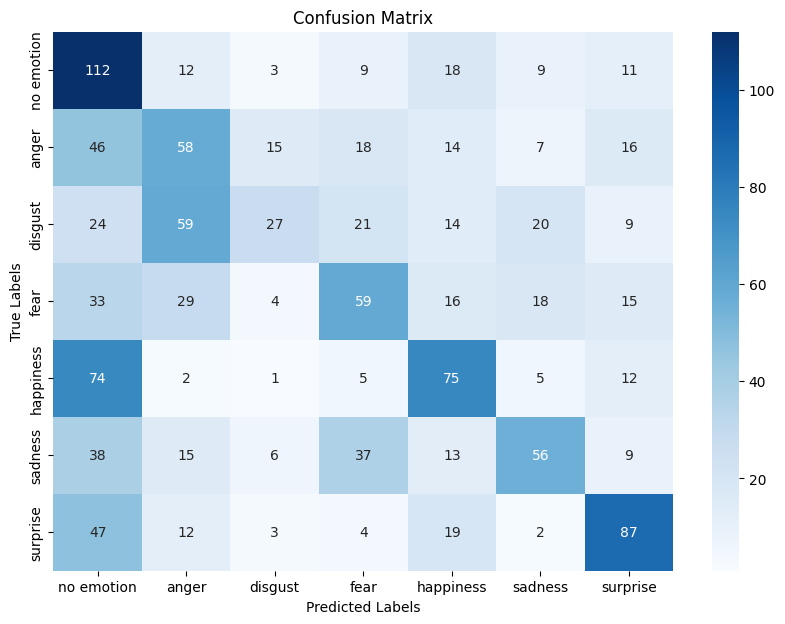

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define class labels based on test_labels
class_labels = [text_labels_dict[i] for i in sorted(text_labels_dict.keys())]

# Compute confusion matrix
conf_matrix = confusion_matrix(sample_labels, prediction_language_model)

# Plot confusion matrix with correct labels
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [68]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute precision, recall, and F1 score
precision = precision_score(sample_labels, prediction_language_model, average='weighted')
recall = recall_score(sample_labels, prediction_language_model, average='weighted')
f1 = f1_score(sample_labels, prediction_language_model, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.4175
Recall: 0.3892
F1 Score: 0.3811
